In [1]:
import numpy as np
import scipy.sparse.linalg as linalg
import sklearn.cluster as cluster
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import community
import itertools
from time import time

In [2]:
def findsubset(e, partition):
    """Finds the subset which contains e
    """
    for i in range(len(partition)):
        if e in partition[i]:
            return i
    return -1

def stochasticblockmodel(n, partition, edge_prob):
    """Returns a stochastic block model graph

    n is the number of vertices
    partition is a partition of {1, ..., n} into disjoint subsets {C_1, ..., C_r}
    edge_prob is a symmetric r*r matrix of edge probabilities
    """
    G = nx.Graph()
    G.add_nodes_from(range(n))
    for i in range(n):
        for j in range(i):
            r_i = findsubset(i, partition)
            r_j = findsubset(j, partition)
            u = np.random.random() # random number in [0,1]
            if u < edge_prob[r_i][r_j]:
                G.add_edge(i, j)
    return G

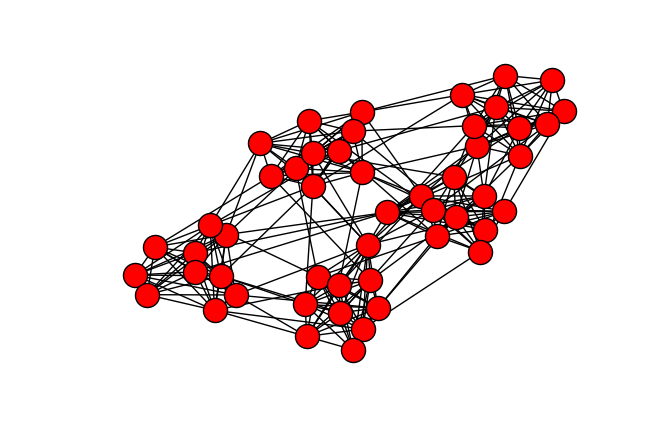

In [3]:
n = 50
r = 5 # r must divide n in this example
part = np.arange(n)
np.random.shuffle(part)
part = part.reshape(r,int(n/r))
probs = np.random.random((r,r)) * 0.1
for i in range(r):
    probs[i,i] = 1

test = stochasticblockmodel(n, part, probs)
nx.draw_spring(test)

In [67]:
def spectralclustering(g, k, l = None):
    """Computes the spectral clustering of graph g in k clusters, 
    using the l first eigenvectors of the unnormalized Laplacian matrix.
    """
    # We compute the Laplacian matrix of g. It is necessary to convert
    # it to floating-point type.
    L = nx.laplacian_matrix(g).asfptype()
    # We compute the first k eigenvectors (the k smallest in magnitude)
    if l is None:
        l = k
    eigs, u = linalg.eigsh(L, l, which='SM')
    kmeans = cluster.KMeans(n_clusters=k).fit(u)
    return kmeans.labels_

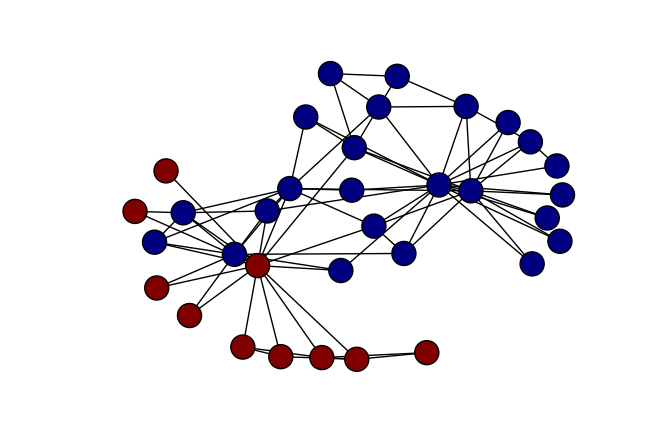

In [69]:
g = nx.karate_club_graph()
labels = spectralclustering(g, 2)
pos = nx.spring_layout(g)
nx.draw(g, pos, node_color=labels)

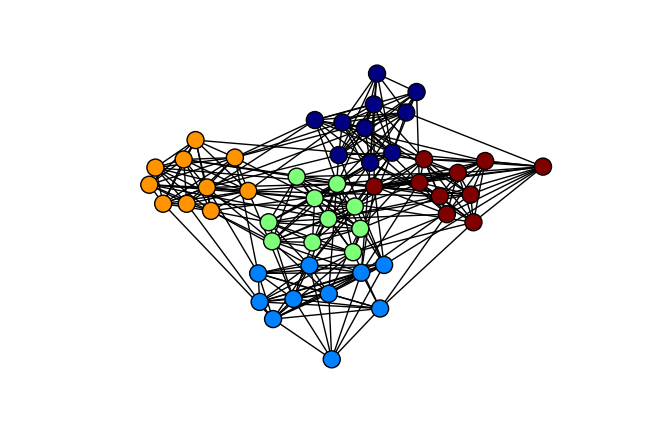

In [71]:
n = 50
r = 5 # r must divide n in this example
part = np.arange(n)
np.random.shuffle(part)
part = part.reshape(r,int(n/r))
probs = np.random.random((r,r)) * 0.2
for i in range(r):
    probs[i, i] = 0.9

test = stochasticblockmodel(n, part, probs)

labels = spectralclustering(test, 5, 6)
pos = nx.spring_layout(test)
nx.draw(test, pos, node_color=labels, node_size=150)

In [73]:
def regularPartition(r, n, verbose = False):
    """Returns the regular partition that will be used"""
    partition = np.arange(r*n).reshape((r,n))
    if verbose:
        print("Regular partition:")
        print(partition)
    return partition

def inOutEdgeMatrix(r, n, cIn, cOut, verbose = False):
    """Creates the edge matrix required to generate the stochastic block model"""
    #print("Edge matrix creation starting !")
    matrix = np.zeros((r,r))
    for i in range(r):
        for j in range(r):
            if i==j:
                matrix[i,j] = float(cIn)/(r*n)
            else:
                matrix[i,j] = float(cOut)/(r*n)
    if verbose:
        print("Edge matrix:")
        print(matrix)
    #print("Edge matrix created !")
    return matrix

def inOutBlockModel(r, n, d, epsilon, verbose = False):
    Matrix = inOutEdgeMatrix(r, n, float(d)/(1+epsilon), float(d*epsilon)/(1+epsilon), verbose)
    return stochasticblockmodel(r*n, regularPartition(r, n, verbose), Matrix)

In [74]:
r = 4
n = 100
d = 16
epsilon = 0.25
G = inOutBlockModel(r, n, d, epsilon, False)

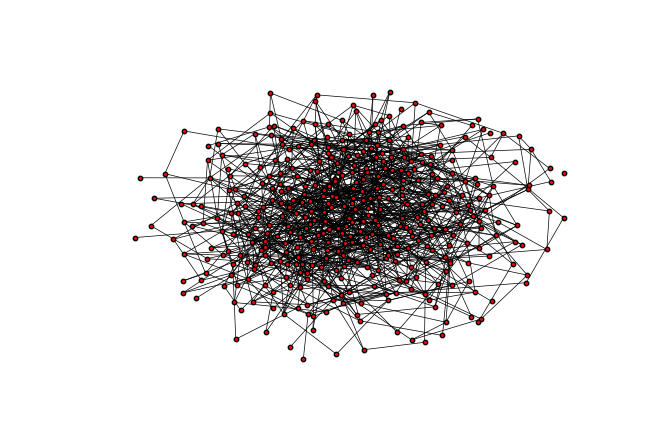

In [75]:
nx.draw(G, pos=nx.spring_layout(G), node_size=10, width=0.5)

In [76]:
node2cluster = community.best_partition(G)

In [77]:
cluster2node = {}
for k, v in node2cluster.items():
    cluster2node.setdefault(v, []).append(k)

In [78]:
for i in cluster2node:
    print("Cluster " + str(i) + ": " + str(len(cluster2node[i])) + " elements")

Cluster 0: 39 elements
Cluster 1: 21 elements
Cluster 2: 25 elements
Cluster 3: 20 elements
Cluster 4: 33 elements
Cluster 5: 35 elements
Cluster 6: 22 elements
Cluster 7: 25 elements
Cluster 8: 38 elements
Cluster 9: 38 elements
Cluster 10: 20 elements
Cluster 11: 30 elements
Cluster 12: 13 elements
Cluster 13: 40 elements
Cluster 14: 1 elements


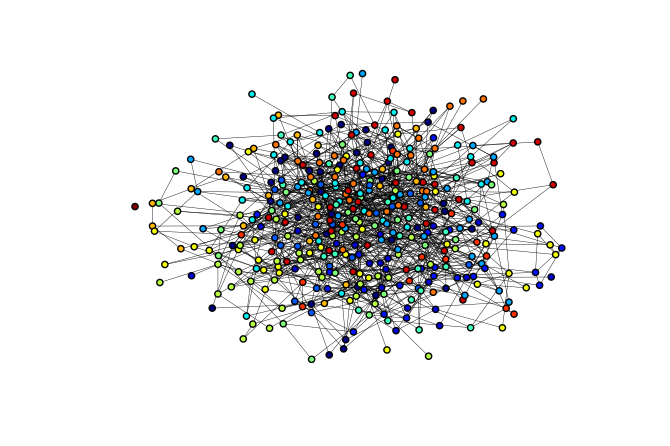

In [79]:
labels = list(node2cluster.values())
pos = nx.spring_layout(G)
nx.draw(G, pos, node_color=labels, node_size=20, width=0.3)

In [80]:
def overlap(r, n, node2cluster, cluster2node):
    maximum = 0
    for pi in itertools.permutations(range(len(cluster2node)), r):
        total = 0
        for i in range(r*n):
            if node2cluster[i] == pi[int(i/n)]:
                total += 1
        result = (float(total)/(r*n) - float(1)/r)/(1 - float(1)/r)
        if result > maximum:
            maximum = result
    return maximum

In [81]:
#print("Overlap calculation")
print(overlap(r, n, node2cluster, cluster2node))
#print("Overlap calculated")
#nx.draw_networkx_edges(G, pos=nx.spring_layout(G), width=0.5)

0


Cluster 0: 12 elements
Cluster 1: 5 elements
Cluster 2: 11 elements
Cluster 3: 6 elements


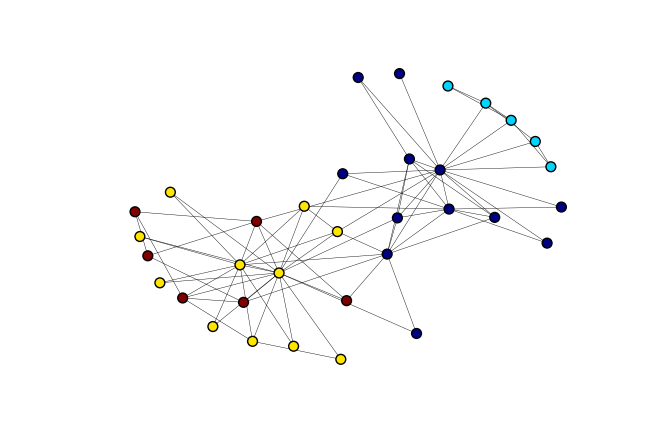

In [86]:
node2cluster = community.best_partition(g)
cluster2node = {}
for k, v in node2cluster.items():
    cluster2node.setdefault(v, []).append(k)

for i in cluster2node:
    print("Cluster " + str(i) + ": " + str(len(cluster2node[i])) + " elements")

labels = list(node2cluster.values())
pos = nx.spring_layout(g)
nx.draw(g, pos, node_color=labels, node_size=50, width=0.3)

2


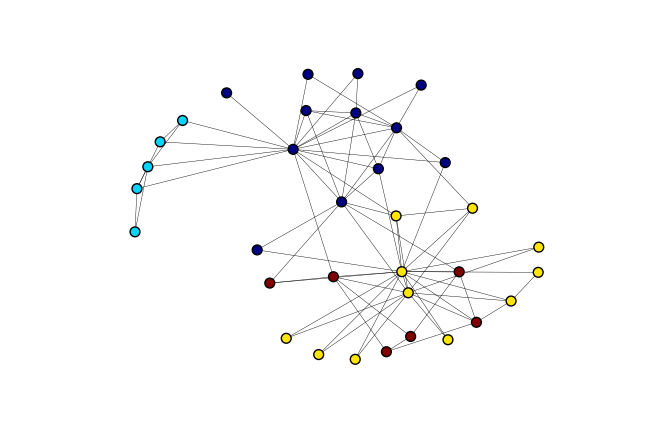

In [88]:
labels = community.generate_dendrogram(g)
print(len(labels))
labels = [labels[1].get(v) for k, v in labels[0].items()]

pos = nx.spring_layout(g)
nx.draw(g, pos, node_color=labels, node_size=50, width=0.3)

Cluster 0: 10 elements
Cluster 1: 10 elements
Cluster 2: 10 elements
Cluster 3: 10 elements
Cluster 4: 10 elements


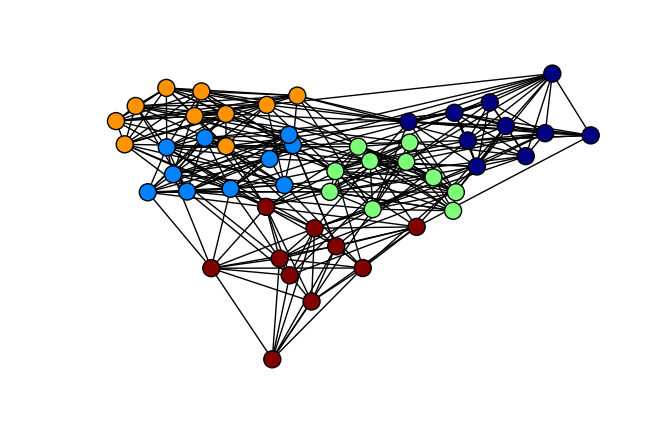

In [91]:
n = 50
r = 5 # r must divide n in this example
part = np.arange(n)
np.random.shuffle(part)
part = part.reshape(r,int(n/r))
probs = np.random.random((r,r)) * 0.2
for i in range(r):
    probs[i, i] = 0.9

test = stochasticblockmodel(n, part, probs)

node2cluster = community.best_partition(test)
cluster2node = {}
for k, v in node2cluster.items():
    cluster2node.setdefault(v, []).append(k)

for i in cluster2node:
    print("Cluster " + str(i) + ": " + str(len(cluster2node[i])) + " elements")

labels = list(node2cluster.values())

pos = nx.spring_layout(test)
nx.draw(test, pos, node_color=labels, node_size=150)

In [113]:
def performance(graph, labels):
    # number of vertices
    n = len(graph)
    # list of edges
    edges = graph.edges()
    count = 0
    for i in range(n):
        for j in range(n):
            if (i, j) in edges and labels[i] == labels[j]:
                count += 1
            elif (i, j) not in edges and labels[i] != labels[j]:
                count +=1
    return count / (n*(n-1))

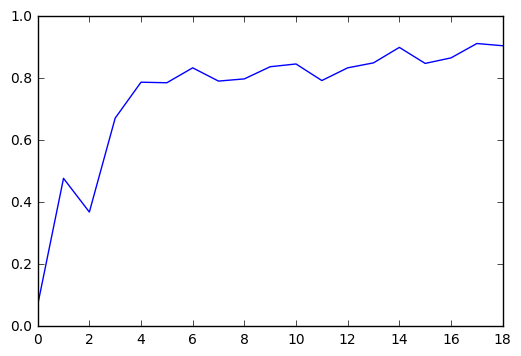

In [124]:
g = nx.karate_club_graph()
perf = []
for k in range(1,20):
    labels = spectralclustering(g, k)
    perf.append(performance(g, labels))
plt.plot(perf)

In [152]:
def modularity(graph, edgeprob, labels):
    n = len(graph)
    m = len(graph.edges())
    A = nx.adjacency_matrix(graph).todense()
    res = 0
    for i in range(n):
        for j in range(n):
            if labels[i] == labels[j]:
                res += A[i,j] - edgeprob[i][j]
    return res / (2*m)

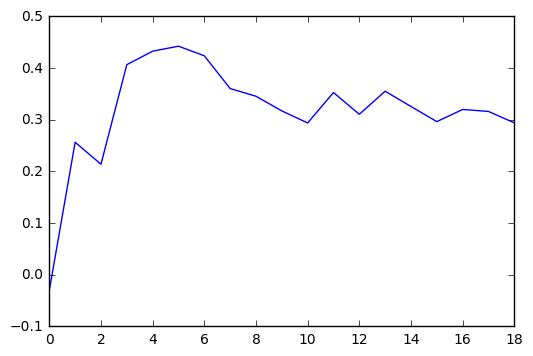

In [153]:
g = nx.karate_club_graph()
edgeprob = np.ones((len(g), len(g))) * nx.density(g)
mod = []
for k in range(1,20):
    labels = spectralclustering(g, k)
    mod.append(modularity(g, edgeprob, labels))
plt.plot(mod)